In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

import nltk
#import ssl

#try:
 #   _create_unverified_https_context = ssl._create_unverified_context
#except AttributeError:
#    pass
#else:
 #   ssl._create_default_https_context = _create_unverified_https_context
#nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nachikethinge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Importing Data

In [69]:
import os

filepath = "Dataset/Books"

df_list = []

for filename in os.listdir(filepath):
    if(filename == ".DS_Store"):
        print("Found .DS_Store")
    else:
        df = pd.read_csv(os.path.join(filepath, filename))
    
        df_list.append(df)


df = pd.concat(df_list)

Found .DS_Store


In [70]:
df.shape

(775177, 21)

In [71]:
df.head()

,Id,Name,Authors,ISBN,Rating,PublishYear,PublishMonth,PublishDay,Publisher,RatingDist5,...,RatingDist3,RatingDist2,RatingDist1,RatingDistTotal,CountsOfReview,Language,PagesNumber,Description,pagesNumber,Count of text reviews
0,1900511,Barbarossa,Christopher Ailsby,1840138009,3.0,2007,4,1,New Line Books,5:0,...,3:1,2:0,1:0,total:1,0,NaN,192.0,"On 22 June 1941, Adolf Hitler launched Operati...",NaN,NaN
1,1900512,Collector's Guide to German World War II: Comb...,Christopher Ailsby,0781802253,0.0,1994,7,1,Hippocrene Books,5:0,...,3:0,2:0,1:0,total:0,0,NaN,160.0,NaN,NaN,NaN
2,1900514,Images of Barbarossa,Christopher Ailsby,0711028257,3.5,2001,1,25,Ian Allan Ltd,5:0,...,3:2,2:1,1:0,total:8,0,NaN,256.0,"On 22 June 1941, Adolf Hitler launched Operati...",NaN,NaN
3,1900520,Romania After 2000: Five New Romanian Plays,Daniel Charles Gerould,0595436560,4.0,2007,9,1,Martin E. Segal Theatre Center Publications,5:1,...,3:1,2:0,1:0,total:6,0,NaN,226.0,The first anthology of new Romanian Drama publ...,NaN,NaN
4,1900521,Global Foreigners: An Anthology of Plays,Saviana Stănescu,1905422423,4.6,2006,12,7,Seagull Books,5:4,...,3:1,2:0,1:0,total:5,0,NaN,320.0,"In Waxing West, Daniella, newly arrived in the...",NaN,NaN


In [72]:
df.memory_usage().sum()/1024**2

130.1108856201172

In [73]:
df.columns

Index(['Id', 'Name', 'Authors', 'ISBN', 'Rating', 'PublishYear',
       'PublishMonth', 'PublishDay', 'Publisher', 'RatingDist5', 'RatingDist4',
       'RatingDist3', 'RatingDist2', 'RatingDist1', 'RatingDistTotal',
       'CountsOfReview', 'Language', 'PagesNumber', 'Description',
       'pagesNumber', 'Count of text reviews'],
      dtype='object')

In [74]:
df['pagesNumber'].describe()

count    2.967960e+05
mean     2.796560e+02
std      8.297538e+03
min      0.000000e+00
25%      1.440000e+02
50%      2.360000e+02
75%      3.340000e+02
max      4.517845e+06
Name: pagesNumber, dtype: float64

In [75]:
df['PagesNumber'].describe()

count    4.783810e+05
mean     2.705894e+02
std      6.539711e+03
min      0.000000e+00
25%      1.330000e+02
50%      2.250000e+02
75%      3.290000e+02
max      4.517845e+06
Name: PagesNumber, dtype: float64

In [76]:
df = df.loc[(df['pagesNumber'] < 334) | (df['PagesNumber'] < 329)]
df.shape

(581165, 21)

In [77]:
df = df.loc[(df['PublishYear'] > 2000) & (df['PublishYear'] < 2020)]
df.shape

(295902, 21)

In [78]:
book_data = df[['Id', 'Name', 'Authors', 'ISBN', 'Rating', 'Description']]
book_data.shape

(295902, 6)

In [79]:
book_data.head()

,Id,Name,Authors,ISBN,Rating,Description
0,1900511,Barbarossa,Christopher Ailsby,1840138009,3.0,"On 22 June 1941, Adolf Hitler launched Operati..."
2,1900514,Images of Barbarossa,Christopher Ailsby,0711028257,3.5,"On 22 June 1941, Adolf Hitler launched Operati..."
3,1900520,Romania After 2000: Five New Romanian Plays,Daniel Charles Gerould,0595436560,4.0,The first anthology of new Romanian Drama publ...
4,1900521,Global Foreigners: An Anthology of Plays,Saviana Stănescu,1905422423,4.6,"In Waxing West, Daniella, newly arrived in the..."
5,1900525,Diary of a Clone,Saviana Stănescu,092338961X,4.8,Poetry. Translation. DIARY OF A CLONE is a sma...


In [4]:
user_rating_0_to_1000 = pd.read_csv("Dataset/User_rating/user_rating_0_to_1000.csv")
user_rating_1000_to_2000 = pd.read_csv("Dataset/User_rating/user_rating_1000_to_2000.csv")
user_rating_2000_to_3000 = pd.read_csv("Dataset/User_rating/user_rating_2000_to_3000.csv")
user_rating_3000_to_4000 = pd.read_csv("Dataset/User_rating/user_rating_3000_to_4000.csv")
user_rating_4000_to_5000 = pd.read_csv("Dataset/User_rating/user_rating_4000_to_5000.csv")
user_rating_6000_to_11000 = pd.read_csv("Dataset/User_rating/user_rating_6000_to_11000.csv")

print(user_rating_1000_to_2000.shape)
print(user_rating_2000_to_3000.shape)
print(user_rating_3000_to_4000.shape)
print(user_rating_4000_to_5000.shape)
print(user_rating_6000_to_11000.shape)

user_rating = pd.concat([user_rating_1000_to_2000, user_rating_2000_to_3000, user_rating_3000_to_4000, user_rating_4000_to_5000, user_rating_6000_to_11000])

print("-----------")
print(user_rating.shape)
print("-----------")


(42986, 3)
(30633, 3)
(46970, 3)
(46903, 3)
(127678, 3)
-----------
(295170, 3)
-----------


## Data Cleaning

In [81]:
len(book_data["ISBN"].unique())
print(f"We have {book_data.shape[0] - len(book_data.ISBN.unique())} duplicate books according to their ISBN number")

We have 1036 duplicate books according to their ISBN number


In [82]:
book_data.drop_duplicates(subset =["ISBN"], inplace = True)
len(book_data.ISBN.unique()) #Should be close to 772855

/var/folders/tz/3f4706312hg_4czj7swryz800000gn/T/ipykernel_10711/2764435279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_data.drop_duplicates(subset =["ISBN"], inplace = True)


294866

In [83]:
book_data.isna().sum()

Id                 0
Name               0
Authors            0
ISBN               1
Rating             0
Description    33482
dtype: int64

In [84]:
book_data = book_data.dropna(subset = ['ISBN'])
book_data['Description'].fillna(book_data['Name'], inplace = True)

/var/folders/tz/3f4706312hg_4czj7swryz800000gn/T/ipykernel_10711/271378893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_data['Description'].fillna(book_data['Name'], inplace = True)


In [85]:
print(book_data.isna().sum())
print(book_data.shape)

Id             0
Name           0
Authors        0
ISBN           0
Rating         0
Description    0
dtype: int64
(294865, 6)


In [86]:
book_data.Name.value_counts()[:30]

Beowulf                            6
Coraline                           6
Orthodoxy                          5
Dogs                               5
Kidnapped                          5
Rapture                            5
Abraham Lincoln                    5
Frank Lloyd Wright                 5
Winston Churchill                  5
Shelter from the Storm             5
Sisters                            5
The Changeling                     5
Stardust                           4
Independence Day                   4
Ancient Rome                       4
Cleopatra                          4
Twilight                           4
Siddhartha                         4
Antigone                           4
Sharks                             4
Heartland                          4
Knitting                           4
The Dark Room                      4
Tiger                              4
Echo                               4
The Outlaw of Torn                 4
Salt                               4
A

In [87]:
book_data.drop_duplicates(subset=["Authors", "Name"], inplace = True)
book_data.Name.value_counts()[:30]

Dogs                         5
Abraham Lincoln              5
Rapture                      5
Winston Churchill            5
Frank Lloyd Wright           5
Colors                       4
Oceans                       4
Benjamin Franklin            4
On the Edge                  4
Desire                       4
Apples                       4
Frida Kahlo                  4
The Messenger                4
If                           4
The Little Mermaid           4
Cleopatra                    4
Hansel and Gretel            4
A Midsummer Night's Dream    4
Shelter from the Storm       4
Sharks                       4
China                        4
Sanctuary                    4
Tiger                        4
Pearl Harbor                 4
Sisters                      4
Hurricanes                   4
When I Grow Up               4
Lost and Found               4
Fish                         4
Out of Order                 4
Name: Name, dtype: int64

In [88]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});') 

def remove_html(html_text): #Referrenced from stackoverflow: https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
    cleantext = re.sub(CLEANR, '', html_text)
    return cleantext

In [89]:
book_data['Description'] = book_data.Description.apply(remove_html)

In [90]:
book_data['Description'] = book_data['Description'].str.lower()

In [91]:
#stopwords = nltk.corpus.stopwords.words("english")

In [93]:
book_data.head()

,Id,Name,Authors,ISBN,Rating,Description
0,1900511,Barbarossa,Christopher Ailsby,1840138009,3.0,"on 22 june 1941, adolf hitler launched operati..."
2,1900514,Images of Barbarossa,Christopher Ailsby,0711028257,3.5,"on 22 june 1941, adolf hitler launched operati..."
3,1900520,Romania After 2000: Five New Romanian Plays,Daniel Charles Gerould,0595436560,4.0,the first anthology of new romanian drama publ...
4,1900521,Global Foreigners: An Anthology of Plays,Saviana Stănescu,1905422423,4.6,"in waxing west, daniella, newly arrived in the..."
5,1900525,Diary of a Clone,Saviana Stănescu,092338961X,4.8,poetry. translation. diary of a clone is a sma...


In [94]:
book_data.shape

(289078, 6)

In [95]:
book_data = book_data[book_data['Rating'] > 2.0]
book_data.shape

(229273, 6)

In [96]:
#count = book_data[book_data['Description'].str.len() > 1000].sum()
#print(count)

In [97]:
def count_rows(row):
    if len(row['Description']) > 500 and (len(row['Description'])) < 1000:
        return 1
    else:
        return 0

count = book_data.apply(count_rows, axis = 1).sum()
print(count)

75885


In [98]:
book_data = book_data.loc[(book_data['Description'].str.len() > 500) & (book_data['Description'].str.len() < 1000)]
book_data.shape

(75885, 6)

In [99]:
book_data.drop_duplicates(subset=["Authors"], inplace = True)

In [100]:
book_data.shape

(54310, 6)

In [101]:
book_data.head()

,Id,Name,Authors,ISBN,Rating,Description
0,1900511,Barbarossa,Christopher Ailsby,1840138009,3.00,"on 22 june 1941, adolf hitler launched operati..."
4,1900521,Global Foreigners: An Anthology of Plays,Saviana Stănescu,1905422423,4.60,"in waxing west, daniella, newly arrived in the..."
12,1900573,"From the Earth to the Moon; And, Round the Moon",Jules Verne,1406554227,3.84,jules gabriel verne (1828-1905) was a french a...
14,1900575,Risky Business (Air Force #2),Merline Lovelace,0373881495,3.71,from career womanto camp fire girl? as regiona...
17,1900580,Complete Kitchens: Plan & Build Your Dream Kit...,Better Homes and Gardens,0696213478,3.50,this is your guide to making your dream kitche...


In [9]:
user_rating.Rating.unique()

array(["This user doesn't have any rating", 'really liked it', 'liked it',
       'it was amazing', 'it was ok', 'did not like it'], dtype=object)

In [10]:
user_rating.shape

(295170, 3)

In [11]:
user_rating = user_rating[user_rating['Rating'] != "This user doesn't have any rating"]

In [12]:
user_rating.shape

(291039, 3)

In [13]:
user_rating.ID.unique()

array([ 1004,  1006,  1059, ..., 10597, 10665, 10879])

In [14]:
user_rating[user_rating['ID'] == 1059]

,ID,Name,Rating
524,1059,Of Mice and Men,liked it
564,1059,"The Da Vinci Code (Robert Langdon, #2)",did not like it
644,1059,Memoirs of a Geisha,did not like it
826,1059,Harry Potter and the Order of the Phoenix (Har...,really liked it
1499,1059,"Eat, Pray, Love",it was ok
1701,1059,Harry Potter and the Deathly Hallows (Harry Po...,really liked it
2132,1059,Middlesex,did not like it
2188,1059,Animal Farm,it was ok
2639,1059,Harry Potter and the Prisoner of Azkaban (Harr...,really liked it
2704,1059,Harry Potter and the Half-Blood Prince (Harry ...,really liked it


In [15]:
set1 = set(book_data['Name'])
set2 = set(user_rating['Name'])

common_books = set1.intersection(set2)

In [16]:
len(common_books)

1978

In [17]:
value_counts = user_rating.Name.value_counts()
user_rating = user_rating[user_rating['Name'].isin(value_counts.index[value_counts > 200])]

In [18]:
user_rating.shape

(25028, 3)

In [19]:
user_rating.ID.unique()

array([1006, 1059, 1063, ..., 9027, 9139, 9549])

In [20]:
user_rating[user_rating['ID'] == 1006]

,ID,Name,Rating
523,1006,Of Mice and Men,really liked it
560,1006,"The Da Vinci Code (Robert Langdon, #2)",liked it
639,1006,Memoirs of a Geisha,liked it
714,1006,1984,it was amazing
781,1006,Pride and Prejudice,it was amazing
821,1006,Harry Potter and the Order of the Phoenix (Har...,it was ok
876,1006,The Kite Runner,it was amazing


In [21]:
user_rating[user_rating['ID'] == 1059]

,ID,Name,Rating
524,1059,Of Mice and Men,liked it
564,1059,"The Da Vinci Code (Robert Langdon, #2)",did not like it
644,1059,Memoirs of a Geisha,did not like it
826,1059,Harry Potter and the Order of the Phoenix (Har...,really liked it
1499,1059,"Eat, Pray, Love",it was ok
1701,1059,Harry Potter and the Deathly Hallows (Harry Po...,really liked it
2132,1059,Middlesex,did not like it
2188,1059,Animal Farm,it was ok
2639,1059,Harry Potter and the Prisoner of Azkaban (Harr...,really liked it
2704,1059,Harry Potter and the Half-Blood Prince (Harry ...,really liked it


In [22]:
def rating_to_num(text):
    if text == "it was amazing":
        return 5
    elif text == "really liked it":
        return 4
    elif text == "liked it":
        return 3
    elif text == "it was ok":
        return 2
    elif text == "did not like it":
        return 1
    else:
        return -1

user_rating['Rating'] = user_rating['Rating'].apply(rating_to_num)
user_rating.Rating.unique()

array([4, 3, 5, 2, 1])

## EDA

In [102]:
#Let's check how do descriptions look like (since they are the main variable)
pd.set_option('display.max_colwidth', -1) 
book_data['Description'][1]

/var/folders/tz/3f4706312hg_4czj7swryz800000gn/T/ipykernel_10711/727104182.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


'set in the beautiful, but poverty stricken region of southwest texas known as the big bend and the corresponding chihuahuan desert of northern mexico, the story depicts the lives of three local marijuanos, whose endless obsession to get high catapults them into the dangerous world of drug smuggling. their journey brings instant success: drugs, money, prostitutes, and notoriety - among their peers, and cops - both bad and good. they soon discover the world of drug smuggling may prove much easier to get into than out of - alive anyway. follow these young men through a world few know intimately, a land of smugglers, outlaws, and desperados, where every living creature seems poised to bite, strike, stick or sting. witness their fight for survival as they battle forces that threaten not only their lives, but their souls as well.'

In [103]:
book_data.columns

Index(['Id', 'Name', 'Authors', 'ISBN', 'Rating', 'Description'], dtype='object')

Text(0, 0.5, 'Frequency')

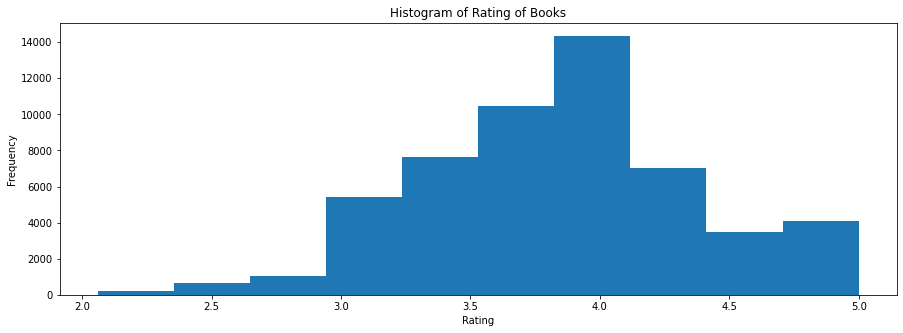

In [7]:
plt.rcParams["figure.figsize"] = (15,5)
plt.hist(book_data['Rating'])
plt.title("Histogram of Rating of Books")
plt.xlabel("Rating")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

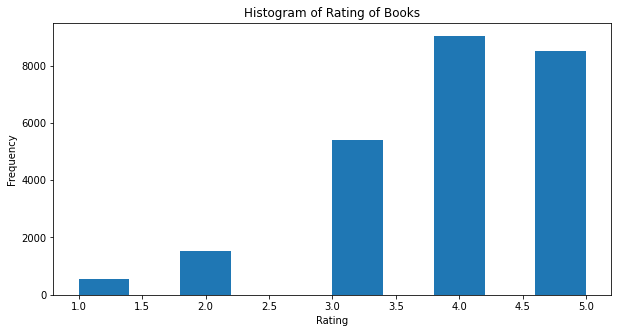

In [24]:
plt.rcParams["figure.figsize"] = (10,5)
plt.hist(user_rating['Rating'])
plt.title("Histogram of Rating of Books by Users")
plt.xlabel("Rating")
plt.ylabel("Frequency")

## Building a TF-IDF Vector

In [106]:

vectorizer = TfidfVectorizer(min_df = 0.1, stop_words = 'english')
model = vectorizer.fit_transform(book_data["Description"])


In [ ]:
cosine_similarity = cosine_similarity(model) 

In [139]:
#np.save("cosine_similarity", cosine_similarity)

In [27]:
#cosine_similarity = np.load("cosine_similarity.npy")

In [3]:
#book_data.to_csv("book_data.csv", index = False)
#book_data = pd.read_csv("book_data.csv")

In [91]:
index = 10392
print(book_data['Name'].iloc[index])
print(book_data['Description'].iloc[index])

A Journey to Palmyra: Collected Essays to Remember Delbert R. Hillers
a journey to palmyra originates from the desire to remember delbert r. hillers, who greatly contributed with his work to palmyrene studies. however, it is not meant just as a memorial volume, but as a research tool. it contains thirteen papers by scholars in the field of palmyrene studies and semitics focusing on different aspects of palmyrene history, social history, art, archaeology and philology, with publication of newly discovered inscriptions. it offers a state-of-the-art discussion on several issues pertaining to the field of palmyrene studies, and illustrates methodologies to be employed in order to increase our knowledge of the complex and multifaceted culture of ancient palmyra and of neighbouring areas.


In [92]:
most_similar = cosine_similarity[index].argsort()[::-1][1:11]
print(most_similar)

[39655 18877  9688 51619 25778 25972 51851 10266  6461 10392]


In [93]:
for i in most_similar:
    print(book_data['Name'].iloc[i])

print("")
print(f"The most similar book was {book_data['Name'].iloc[most_similar[0]]}")
print("")
print(f"The description of the book is: \n\n{book_data['Description'].iloc[most_similar[0]]}")


Pilgrim Voices: Narrative and Authorship in Christian Pilgrimage
Letters to Ted
Queering Public Address: Sexualities in American Historical Discourse
Introduction to Theatre Arts: A 36-Week Action Handbook
A History of Science in Society, Volume 2: From Philosophy to Utility
Readers Theatre for American History
Disciplinary Styles in the Scholarship of Teaching and Learning: Exploring Common Ground
We Gotta Get Out Of This Place: The True, Tough Story Of Women In Rock
Locating Air Force Base Sites: History's Legacy
A Journey to Palmyra: Collected Essays to Remember Delbert R. Hillers

The most similar book was Pilgrim Voices: Narrative and Authorship in Christian Pilgrimage

The description of the book is: 

research on pilgrimage has traditionally fallen across a series of academic disciplines - anthropology, archaeology, art history, geography, history and theology. to date, relatively little work has been devoted to the issue of pilgrimage as writing and specifically as a form of tr

## User-User recommendation system

In [66]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


user_book_matrix = user_rating.pivot_table(index='ID', columns='Name', values='Rating')
user_book_matrix = user_book_matrix.fillna(0)

user_similarity = cosine_similarity(user_book_matrix)


def recommend(user_id, user_similarity=user_similarity, n_recommend = 10):

    user_similarity_df = pd.DataFrame(user_similarity, index=user_book_matrix.index, columns=user_book_matrix.index)

    similar_users = user_similarity_df.loc[user_id]


    unread_books = user_book_matrix.loc[user_id][user_book_matrix.loc[user_id] == 0].index


    ratings = user_book_matrix.loc[similar_users.index].loc[:, unread_books].mean()


    return ratings.sort_values(ascending=False)[:n_recommend]

def get_similar_user(user_id):
    user_similarity_df = pd.DataFrame(user_similarity, index=user_book_matrix.index, columns=user_book_matrix.index)

    similar_users = user_similarity_df.loc[user_id]
    
    return similar_users.sort_values(ascending=False)[1:10]


In [58]:
recommend(user_id = 1059, n_recommend = 5)

Name
1984                      1.024487
The Kite Runner           0.971959
Pride and Prejudice       0.757504
Me Talk Pretty One Day    0.682859
Slaughterhouse-Five       0.666272
dtype: float64

In [67]:
get_similar_user(1059)

ID
9572     0.737820
3699     0.737231
10098    0.728564
3983     0.723863
5200     0.719487
4924     0.714625
2090     0.706462
8610     0.705221
3628     0.704940
Name: 1059, dtype: float64

In [68]:
print("User 1059 is most similar with User 9572 and User 3699")

User 1059 is most similar with User 9572 and User 3699
